## Corner Challenge - Mustard Systems.

Before discussing the distribution of the data and the methods to tackle the assignment, I first load and visualise the data.

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import sys
import torch.nn as nn
from scipy import stats
np.set_printoptions(precision=5)
pd.options.display.float_format = '{:,.3f}'.format
from math import factorial as fac

In [44]:
# Load in the CSVs
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [45]:
#Add total corners
train_df['total_corners'] = train_df['Home_Corners']+train_df['Away_Corners']

In [46]:
#Just viewing the data
train_df[:20]

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Home_Goals,Away_Goals,Home_Corners,Away_Corners,total_corners
0,2826,793,02/04/2005,410,908,2.000,0.000,15,1,16
1,2827,793,02/04/2005,338,597,3.000,2.000,3,6,9
2,2828,793,02/04/2005,1364,246,2.000,3.000,13,2,15
3,2829,793,02/04/2005,1088,1397,1.000,0.000,2,5,7
4,2830,793,02/04/2005,830,1412,2.000,3.000,3,6,9
5,2832,793,02/04/2005,548,357,1.000,1.000,7,8,15
6,2834,793,02/04/2005,1049,1090,4.000,1.000,5,8,13
7,2837,793,02/04/2005,870,1026,2.000,0.000,6,4,10
8,2839,793,02/04/2005,1034,1383,2.000,2.000,5,2,7
9,2840,793,02/04/2005,715,662,2.000,2.000,9,7,16


------

### Section 1. Data Exploration 

In this section I look at how the variables of interest are distributed. In particular, I will look at the distribution of home corners, away corners and total corners.

The data is count-based data and the obvious distribution to follow is therefore the poisson distribution. This has also been widely used before in the literature for modelling goals and corners.

I will also look at how these distributions vary by league.

Finally, I run a Kullback-Leibler test on a Poisson distribution and a novel variance-adjusted Poisson distribution (VAP)

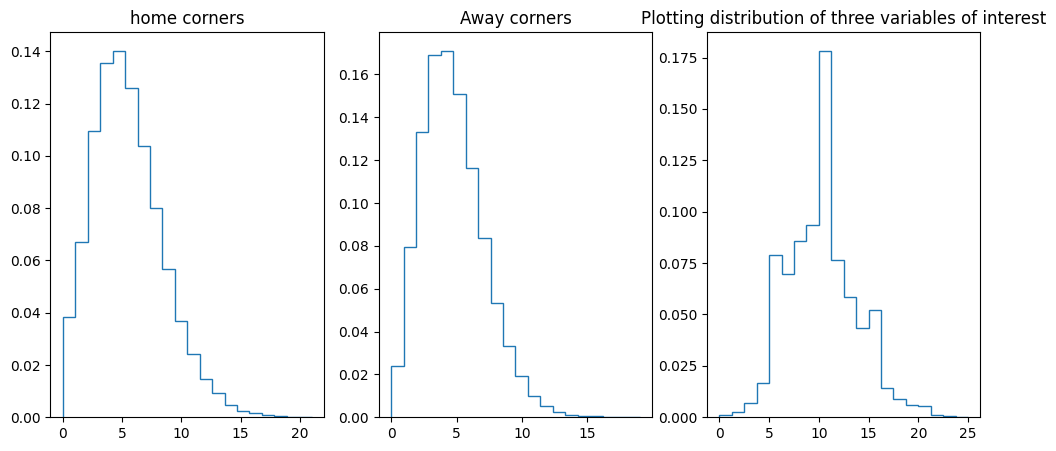

,Means,Variance,Var-to-mean ratio
Home,5.726,8.092,1.413
Away,4.493,6.277,1.397
Total,10.219,11.915,1.166


In [47]:

fig, axlist = plt.subplots(nrows=1,ncols=3, figsize=(12,5))
axlist = axlist.flatten()
variables_of_interest = train_df['Home_Corners'], train_df['Away_Corners'], train_df['total_corners']
for v, a in zip(variables_of_interest, axlist):
    a.hist(v,bins=20, histtype='step',density=True)
axlist[0].set_title("home corners")
axlist[1].set_title("Away corners")
axlist[2].set_title("total corners")
plt.title("Plotting distribution of three variables of interest")
plt.show()
mean_home, var_home = np.mean(variables_of_interest[0]), np.var(variables_of_interest[0])
mean_away, var_away = np.mean(variables_of_interest[1]), np.var(variables_of_interest[1])
mean_total, var_total = np.mean(variables_of_interest[2]), np.var(variables_of_interest[2])
pd.DataFrame({"Means": [mean_home, mean_away, mean_total], "Variance": [var_home, var_away, var_total], "Var-to-mean ratio":\
              [var_home/mean_home, var_away/mean_away, var_total/mean_total]},index=['Home','Away','Total'])
                                                                                                     
# print(mean_home, var_home, var_home/mean_home)
# print(mean_away, var_away, var_away/mean_away)
# print(mean_total, var_total, var_total/mean_total)

----

All three variables of interest appear to follow a distribution reasonably approximating a poissson distribution, with the exception of the fact that the variance is higher than the mean for all three variables of interest. This is likely due to the auto-correlation exhibited by corners (specifically, one corner is quite likely to immediately lead to another corner).

Before considering how the poisson distribution could be altered to encompass this feature, I first compare the summary statistics of the individual leagues.


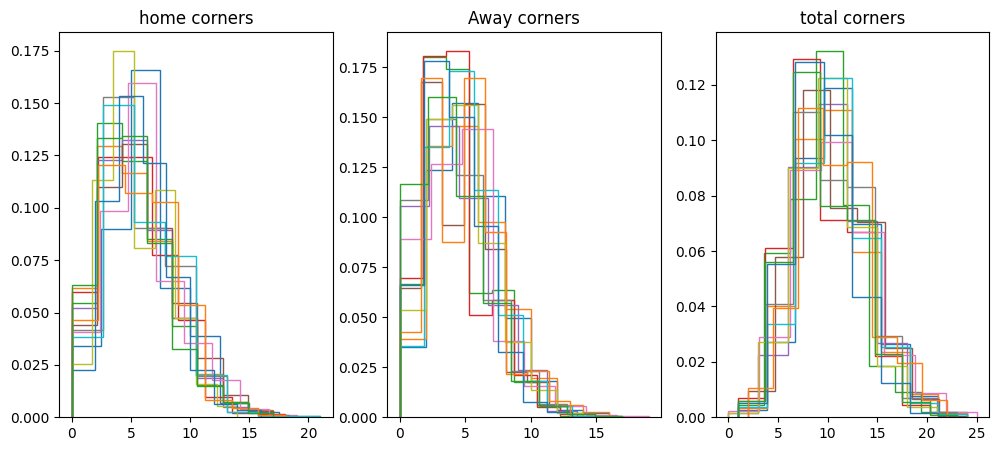

,0,1,2,3,4,5,6,7,8,9,10,11,12
Mean,10.971,10.506,9.695,9.487,10.097,10.624,10.894,10.251,9.744,10.726,9.427,10.585,9.642
Variance,12.250,13.034,10.648,11.300,11.324,12.042,13.198,11.706,10.269,12.007,10.278,12.896,10.852
Game count,"2,658.000","1,010.000","1,540.000","1,817.000","2,362.000","1,939.000","1,912.000","1,983.000","1,551.000","2,350.000","1,760.000",689.000,"2,259.000"


In [48]:
fig, axlist = plt.subplots(nrows=1,ncols=3, figsize=(12,5))
axlist = axlist.flatten()
uniques_leagues = list(train_df['LeagueId'].unique())
total_corners_means = []
total_corners_vars = []
total_games = []
for ul in uniques_leagues:
    df = train_df[train_df['LeagueId'] == ul]
    variables_of_interest = df['Home_Corners'], df['Away_Corners'], df['total_corners']
    for v, a in zip(variables_of_interest, axlist):
        a.hist(v,bins=8, histtype='step',density=True)
    total_corners_means.append(np.mean(df['total_corners']))
    total_corners_vars.append(np.var(df['total_corners']))
    total_games.append(len(df['total_corners']))
axlist[0].set_title("home corners")
axlist[1].set_title("Away corners")
axlist[2].set_title("total corners")
plt.show()
display(pd.DataFrame({"Mean": total_corners_means, "Variance": total_corners_vars, "Game count": total_games}).T)

Visually it appears that all leagues follow a similar distribution. However, the means and variances of each league in the train data is relatively different. This may be the effect of random noise, although the sample sizes suggest there may be a significant difference in the true means and variances of corners by league.

------

#### Introducing Variable-adjusted Poisson and using Kullback-Liebler divergence as a method to analyse the most effective distribution for modellign corners

I now attempt to adjust for the variance-to-mean ratio by introducing a somewhat 'hacky' technique to force a higher variance distribution.

First, I show that the KL score for using the poisson distribution on the sample data is 0.202. This score is a measure of divergence, so a lower score is better.

I then introduce the VAP by softening the peak of the curve using a temperature θ and an offsetting value epsilon to ensure the mean is kept constant. The values of θ and epsilon were set using trial and error in order to fit a distribution with the same mean and variance of the sample data. I show that the VAP distribution has a KL score of 0.185, slightly improved on the Poisson distribution.

Finally, I plot the two distributions side by side over the data.

In [49]:
def poissonPDF(lamb, k):
    return (lamb**k) * np.exp(-lamb) / fac(int(k))

In [50]:
## First, retrieve the density values for each number of corners
max_corners = np.max(train_df['total_corners'])+2
observed_vals = np.histogram(train_df['total_corners'],density=True,bins=max_corners)[0]

## Then, create a poisson distribution ranging from 0 to observed values (with a buffer of 2).
x = np.linspace(0,len(observed_vals)-1,len(observed_vals))
poisson_pdf = [poissonPDF(np.mean(train_df['total_corners']),x) for x in x]

## Print the KL_Score
KL_score = np.sum(observed_vals * np.log(observed_vals/poisson_pdf+1e-6))
print("Kullback-Liebler Score for Poisson distribution %.3f" %KL_score)


Kullback-Liebler Score for Poisson distribution 0.202


Kullback-Liebler Score for VAP 0.185
KL summary stats: mean 10.226 / var 11.916 / var to mean 1.165: 


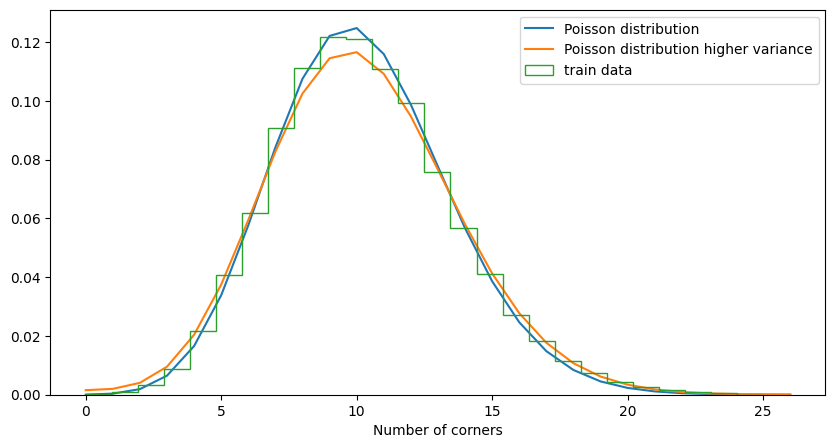

In [51]:
## COMPARING TO THIS KL_SCORE if I use a transformed poisson to generate a higher variance
def poissonPDF_adj(lamb, k,theta):
    return np.exp(-lamb) *((lamb**k) / fac(int(k)))**(theta) + np.max([0,lamb-k])*6e-5

lamb = np.mean(train_df['total_corners'])
theta = 0.885; y_adj = [poissonPDF_adj(lamb, i, theta)/np.sum([poissonPDF_adj(lamb, i, theta) for i in x]) for i in x]
observed_vals = np.histogram(train_df['total_corners'],density=True,bins=max_corners)[0]
x = np.linspace(0,len(observed_vals)-1,len(observed_vals))
KL_score_adj = np.sum(observed_vals * np.log(observed_vals/y_adj+1e-6))
print("Kullback-Liebler Score for VAP %.3f" %KL_score_adj)

for i in [y_adj]:
    vals = []
    for a,b in zip(x, i):
        for _ in range(int(b*1000000)):
            vals.append(a)
    print('KL summary stats: mean %.3f / var %.3f / var to mean %.3f: ' % (np.mean(vals), np.var(vals), np.var(vals)/np.mean(vals)))

    
### so y_adj is a slightly flatter distribution

plt.figure(figsize=(10,5))
plt.plot(poisson_pdf,label = 'Poisson distribution')
plt.plot(y_adj,label = 'Poisson distribution higher variance') 
plt.hist(train_df['total_corners'],histtype='step',density=True, label='train data',bins=26)
plt.legend()
plt.xlabel("Number of corners")
plt.show()

-----

### 2 Creating Explanatory Variables

I propose to create 8 indexes of a team’s sporting performance (SPIs). These indices split a team’s performance by home/away performance, and measure their relative proficiency at scoring/achieving goals/corners. So for each team, I want an SPI for each of the following:

- Home corner scoring / Away corner scoring
- Home corner defending / Away corner defending
- Home goal scoring / Away goal scoring
- Home goal defending / Away goal scoring

I split it this way for several reasons. Teams are clearly better at scoring corners at home than away (5.73 v 4.49) but this gap may not be uniform between teams (some teams may have a larger/smaller gap due to playing style). Goals scored may provide information on a team’s general supremacy, or on a team’s style of play (“Attacking-ness”). 

To generate SPIs for each team, I propose using a rolling average, with a discount (rho = 0.9) factor, s.t. SPIkt+1 =  rhoSPIkt + (1-rho)rt+1  where SPIK refers to a specific SPI, and rt+1 refers to a result for that KPI at time t+1. Concretely, a teams away corner scoring SPI at time t+1 is equal to 0.9 times their away corner scoring SPI at time t plus 0.1 times an opponent-adjusted value for number of corners scored in match at time t+1. The opponent-adjusted value is calculated by measuring the quality of their opponent at conceding scorers (so, a team plays another team who has historically been very good at not giving up many corners, a high corner count will result in a bigger boost to their away corner scoring SPI). 

** Expl_Variable_Creationg contains the relevant functions for this, and the results are shown below

#### Data Preparation

In [52]:
import expl_variable_creation
import importlib
importlib.reload(expl_variable_creation)
from expl_variable_creation import initialisate_leagues, perform_update, create_training_set, create_val_set, get_x_values_one_team


In [53]:
leagues = initialisate_leagues(uniques_leagues, only_train_df,zero_means=False)

----

In [54]:
### Create arrays for each different league. Also create the above / below thresholds from 9-12 with (above and below each).
### Create validation set
val_df = train_df.iloc[-3000:]
only_train_df = train_df[:-3000]                       

In [18]:
train_leagues_table, x_train, y_train = create_training_set(uniques_leagues, only_train_df, bootstrap_value=0, rho=0.9, unit_test=False,zero_means=False)
val_leagues_table, x_val, y_val = create_val_set(uniques_leagues, val_df, train_leagues_table,zero_means=False)

We can then review how the evolution of a particular team during the training period looks for an individual team. We review team 1056, and look at their home games.

In the first view, the global average is used as a baseline for sporting performance index, so a teams' SPI refers to their relative superiority over the average for a particular index.

We can toggle the "Zero means" parameter in the "create_training_set" function to look at a team's performance without using a global mean, which I use when using a Poisson distribution to model expected corners.

In [19]:
#### RELATIVE PERFORMANCE
display(train_leagues_table[813].table[train_leagues_table[813].table['HomeTeamId']==1056][:25])

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Home_Goals,Away_Goals,Home_Corners,Away_Corners,total_corners,H_ATT,H_DEF,H_ATT_goals,H_DEF_goals,A_ATT,A_DEF,A_ATT_goals,A_DEF_goals
0,5369,813,24/04/2005,1056,258,1.000,2.000,4,6,10,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
185,61402,813,27/03/2006,1056,1369,1.000,1.000,6,6,12,-0.173,-0.117,-0.059,-0.080,-1.381,-0.125,0.508,-0.209
217,61434,813,08/04/2006,1056,585,0.000,1.000,11,4,15,-0.114,-0.364,-0.104,-0.075,0.623,0.590,-0.529,0.224
244,66352,813,06/05/2006,1056,2488,1.000,2.000,4,2,6,0.547,-0.295,-0.200,-0.036,0.059,0.343,-0.508,0.069
264,67359,813,15/05/2006,1056,439,1.000,1.000,13,6,19,0.368,-0.064,-0.188,-0.157,-0.045,0.579,0.103,-0.150
282,68986,813,27/05/2006,1056,434,0.000,1.000,3,2,5,1.203,-0.233,-0.224,-0.117,0.401,0.170,-0.130,0.167
295,70368,813,10/06/2006,1056,2487,1.000,1.000,7,3,10,0.916,0.086,-0.313,-0.130,-1.133,0.336,0.363,-0.072
319,71509,813,24/06/2006,1056,1404,1.000,0.000,2,5,7,1.069,0.164,-0.300,-0.111,0.266,-0.026,0.392,-0.139
337,72921,813,22/07/2006,1056,340,1.000,0.000,2,2,4,0.673,-0.046,-0.259,0.012,-0.478,0.634,0.022,0.080
382,75009,813,26/08/2006,1056,690,1.000,0.000,3,5,8,0.280,0.100,-0.230,0.055,0.383,0.049,0.184,0.356


In [20]:
#### NO GLOBAL MEAN USED
#### RELATIVE PERFORMANCE
train_leagues_table, x_train, y_train = create_training_set(uniques_leagues, only_train_df, bootstrap_value=0, rho=0.9, unit_test=False,zero_means=True)
val_leagues_table, x_val, y_val = create_val_set(uniques_leagues, val_df, train_leagues_table,zero_means=True)
display(train_leagues_table[813].table[train_leagues_table[813].table['HomeTeamId']==1056][:25])

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Home_Goals,Away_Goals,Home_Corners,Away_Corners,total_corners,H_ATT,H_DEF,H_ATT_goals,H_DEF_goals,A_ATT,A_DEF,A_ATT_goals,A_DEF_goals
0,5369,813,24/04/2005,1056,258,1.000,2.000,4,6,10,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
185,61402,813,27/03/2006,1056,1369,1.000,1.000,6,6,12,0.400,0.600,0.100,0.200,1.087,2.124,1.232,0.743
217,61434,813,08/04/2006,1056,585,0.000,1.000,11,4,15,0.715,1.062,0.124,0.257,3.384,1.659,0.261,0.387
244,66352,813,06/05/2006,1056,2488,1.000,2.000,4,2,6,1.618,1.171,0.080,0.268,1.727,0.986,0.077,0.286
264,67359,813,15/05/2006,1056,439,1.000,1.000,13,6,19,1.741,1.183,0.179,0.450,2.584,1.570,0.844,0.726
282,68986,813,27/05/2006,1056,434,0.000,1.000,3,2,5,2.671,1.446,0.176,0.436,1.795,0.952,0.227,0.134
295,70368,813,10/06/2006,1056,2487,1.000,1.000,7,3,10,2.631,1.329,0.152,0.502,0.446,0.929,0.767,0.406
319,71509,813,24/06/2006,1056,1404,1.000,0.000,2,5,7,3.019,1.433,0.226,0.532,1.560,1.058,0.726,0.410
337,72921,813,22/07/2006,1056,340,1.000,0.000,2,2,4,2.748,1.728,0.298,0.431,2.087,1.445,0.740,0.480
382,75009,813,26/08/2006,1056,690,1.000,0.000,3,5,8,2.349,1.577,0.329,0.386,2.971,2.057,0.877,0.179


----

#### Data Preparation.

We now need to prepare the data in a form such that we can train the model. I will use pyTorch for model training. This has the benefit of being able to create bespoke models and loss functions. It has the downside of not providing p values for individual variables.

As all the lines in the test set are between 9 and 12, I will transform the y values into two usable formats. Firstly, I will one-hot-encode the y values to represent the total number of corners in a single match. Secondly, I will provide over/under binary values for each value in the range 9-12 (so 8 over-under values in total, e.g. 'below 9').

The reason for doing this is that, ultimately, the thing we care about most is to be able to accurately estimate the probability of a game having more/less than a given threshold. This is ultimately what we want to bet on.

I will also transform the x values into tensors. When using positive-only values for inputs, I wil also standardise in the range (0-1).

In [55]:
import Data_preparation
from Data_preparation import x_Y_transform, Dataset
importlib.reload(Data_preparation)
y_train_1h, y_train_thresh_tensor, y_train_thresholds_nonTensor, x_train_tensor = x_Y_transform(x_train, y_train,max_val=max_corners)
y_val_1h, y_val_thresh_tensor, y_val_thresholds_nonTensor, x_val_tensor = x_Y_transform(x_val, y_val,max_val=max_corners)

In [56]:
print("Shapes")
print("Y train 1h: ", y_train_1h.shape)
print("Y train thresholds tensor: ", y_train_thresh_tensor.shape)
print("X train tensor: ", x_train_tensor.shape)

Shapes
Y train 1h:  torch.Size([20607, 27])
Y train thresholds tensor:  torch.Size([20607, 8])
X train tensor:  torch.Size([20607, 17])


#### Benchmarks

Before building a model (or models) to predict the number of corners, let's first establish a couple of benchmarks for each of the thresholds.

The two obvious benchmarks are to use the global and league-level averages for % chance of each of the thresholds.

We can see two things from the table of thresholds printed below.

1. In some cases, the threshold is very likely/unlikely to be true... e.g. over two thirds of games have less than 12 corners and two thirds of games have more than 9 corners.

2. There are reasonably significant league-level differences in the training data.

In [57]:
import warnings
warnings.filterwarnings('ignore')
##### GLOBAL AVERAGE MODEL

thresholds = []
targets_for_baselines = []
for tgt in [9,10,11,12]:
    thresholds.append(f'below_{tgt}'); thresholds.append(f'above_{tgt}')
    targets_for_baselines.append(y_train_thresholds_nonTensor[tgt][0]); targets_for_baselines.append(y_train_thresholds_nonTensor[tgt][1]) #so we get a list of lists here
targets_global_baseline = np.array(targets_for_baselines)

global_means = np.sum(targets_global_baseline,axis= 1)/ (targets_global_baseline.shape[1]) #8 bit vector... this gives us the probabilities to predict
summary_thresh_df = pd.DataFrame(data=global_means).T

#### LEAGUE BASED AVERAGE MODEL.
league_means = {}
targets_league = targets_global_baseline.T
        
for ul in range(0,13):
    means = []
    l = targets_league[(x_train_tensor.numpy()[:,-1]==ul)]
    l= l.T
    means = np.sum(l, axis=1) / l.shape[1]
    league_means[ul] = means
    summary_thresh_df = summary_thresh_df.append(pd.DataFrame(means).T)

summary_thresh_df.columns = thresholds
summary_thresh_df=summary_thresh_df.reset_index()
summary_thresh_df['index'] = ["Total"] + list(range(0,13))
display(summary_thresh_df)


,index,below_9,above_9,below_10,above_10,below_11,above_11,below_12,above_12
0,Total,0.326,0.557,0.443,0.440,0.560,0.334,0.666,0.238
1,0,0.251,0.639,0.361,0.514,0.486,0.411,0.589,0.298
2,1,0.288,0.589,0.411,0.465,0.535,0.362,0.638,0.269
3,2,0.369,0.507,0.493,0.385,0.615,0.275,0.725,0.188
4,3,0.421,0.453,0.547,0.348,0.652,0.261,0.739,0.174
5,4,0.347,0.535,0.465,0.422,0.578,0.310,0.690,0.220
6,5,0.294,0.599,0.401,0.489,0.511,0.389,0.611,0.286
7,6,0.272,0.626,0.374,0.521,0.479,0.406,0.594,0.316
8,7,0.311,0.572,0.428,0.449,0.551,0.337,0.663,0.241
9,8,0.367,0.503,0.497,0.392,0.608,0.275,0.725,0.185


----

#### Benchmarks cont'd

So, let's create two models to predict the over/under thresholds for a given match. Model 1 will use the global average for each threshold and model 2 will use the league-level average for each threshold. I will assess these models on the validation set using two important metrics.

1. Accuracy - Using a binary threshold, what % of the time does the model predict the correct threshold result.

2. Mean Squared Error between prediction and true result. This is important because, when estimating probabilities, the optimal prediction will minimise the mean squared error of an event.


In [58]:
class global_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.FC_dummy = nn.Linear(1,1) #unused.
        
    def forward(self, catted_stats):
        output = []
        for i in range(catted_stats.shape[0]):
            output.append(torch.tensor(global_means).float())
        output = torch.stack(output,0)
        return output
        
class national_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.FC_dummy = nn.Linear(1,1) #unused.

    def forward(self, catted_stats):
        output = []
        for i in range(catted_stats.shape[0]):
            idx = int(catted_stats[i][-1].detach().numpy())
            output.append(torch.tensor(league_means[idx]).float())
        output = torch.stack(output,0)
        return output

---- 



In [59]:
## LOAD DATA INTO A DATALOADER - I use this setup for the later models so for ease I will use it here too.
batch_size = 512
train_dataset = Dataset(x= x_train_tensor, y_1h= y_train_1h, y_thresh=y_train_thresh_tensor)
val_dataset = Dataset(x = x_val_tensor, y_1h = y_val_1h, y_thresh=y_val_thresh_tensor)
train_gen = torch.utils.data.DataLoader(train_dataset, shuffle=True,batch_size=batch_size)
val_gen = torch.utils.data.DataLoader(val_dataset, shuffle=True,batch_size=batch_size)

In [60]:
#### The Training function model has functions to train three different types of model. 

#For simplicity, this can be used to measure the performance of the global averaging model (i set trainable to false)

import training_functions
importlib.reload(training_functions)
from training_functions import train_model_thresholds, train_model_poisson, train_model_softmax
import loss_functions
importlib.reload(loss_functions)
from loss_functions import loss_func_thresholds, MSE,Loss_function_poisson_adj

In [61]:
print("===Running Model with global averages===")
model_global_mean = global_model()
loss_func = loss_func_thresholds
optimizer = torch.optim.SGD(model_global_mean.parameters(),lr=1e-2) ### obsolete, won't be trained.
val_loss, val_acc = train_model_thresholds(model_global_mean, train_gen, val_gen, loss_func, MSE, optimizer,epochs=1, trainable=False)

print("\n===Running Model with league averages===")
model_league_mean = national_model()
loss_func = loss_func_thresholds
optimizer = torch.optim.SGD(model_league_mean.parameters(),lr=1e-2) ### obsolete, won't be trained.
val_loss, val_acc = train_model_thresholds(model_league_mean, train_gen, val_gen, loss_func, MSE, optimizer,epochs=1, trainable=False)

===Running Model with global averages===
==END OF EPOCH 1===

Train accuracy: 0.6250363953996215
Train loss: 0.0
Val accuracy: 0.6203333333333333
Val MSE: 0.2311849743127823

===Running Model with league averages===
==END OF EPOCH 1===

Train accuracy: 0.6312842723346436
Train loss: 0.0
Val accuracy: 0.6161666666666666
Val MSE: 0.231167271733284


---

Conclusion: Using league averages results in higher accuracy on the training set but a lower level of accuracy on the validation set, suggesting the league averages may somewhat be down to randomness in the train set.

However, the league averages does result in a slighly lower MSE score on the validation set, suggesting the league idx may have some useful information in predicting the PROBABILITY of a certain number of corners.

Nevertheless, these two modesl provide us with useful benchmarks for analysing the effectiveness of the models.

----
----

### Models 

I will test four different models. These models are:

1. Poisson model - here we try to predict the correct value of λ for a given game, given the explanatory variable inputs. This is then converted to a probability distribution in order to predict the % chance of being above/below each threshold.

2. Variable-adjusted poisson model (VAP).

3. 3-layer neural network to predict number of corners in a game - here, I approach the problem as a classification problem, where each number of corners is said to be a specific 'category'. 

4. 3-layer neural network to predict 8 binary outputs (specifically, it predicts the probability of being over/under for each of the threshold values).

With the poisson model, I use the standard poisson loss function (loss(Β) = λ - ylog(λ)

For the VAP model, I use an approximated loss function (loss(Β) = λ - θylog(λ)

For model 3, I use a softmax loss function.

For model 4, which is a binary classification, I use binary cross-entropy.

Ultimately, I measure the ability of each model to accurately predict the above/under thresholds. This is measured through

a) Accuracy rate (% times it gets it right assuming a 50% threshold)

b) MSE (Which the optimal model aims to minimise, and reflects accuracy in terms of the accurately predicting the percentage chance for a given game)

In [62]:
def dataloader_generator(unique_leagues, bootstrap_value, rho, zero_means,batch_size=64,shuffle=True):
    train_leagues_table, x_train, y_train = create_training_set(uniques_leagues, only_train_df, bootstrap_value=bootstrap_value, rho=rho, unit_test=False,zero_means=zero_means)
    val_leagues_table, x_val, y_val = create_val_set(uniques_leagues, val_df, train_leagues_table,zero_means=zero_means)
    y_train_1h, y_train_thresh_tensor, y_train_thresholds_nonTensor, x_train_tensor = x_Y_transform(x_train, y_train,max_val=max_corners)
    y_val_1h, y_val_thresh_tensor, y_val_thresholds_nonTensor, x_val_tensor = x_Y_transform(x_val, y_val,max_val=max_corners)
    train_dataset = Dataset(x= x_train_tensor, y_1h= y_train_1h, y_thresh=y_train_thresh_tensor)
    val_dataset = Dataset(x = x_val_tensor, y_1h = y_val_1h, y_thresh=y_val_thresh_tensor)
    train_gen = torch.utils.data.DataLoader(train_dataset, shuffle=shuffle,batch_size=batch_size)
    val_gen = torch.utils.data.DataLoader(val_dataset, shuffle=shuffle,batch_size=batch_size)
    return train_gen, val_gen
    

In [63]:
class Poisson_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.FC1 = nn.Linear(17, 1) #10 inputs (2 teams x 4, league averages), 8 outputs (9->12, above and below)
        
    def forward(self, catted_stats):
        x = torch.exp(self.FC1(torch.log(catted_stats+0.01)))
        return x

In [64]:
### Loss and helper functions for poisson

import Prediction_functions
from Prediction_functions import prediction_function_poisson,poissonPDF_adj
importlib.reload(Prediction_functions)
loss_function_poisson = nn.PoissonNLLLoss(log_input=False)

In [34]:
theta = 0.885 # 0.885/ False

train_gen, val_gen = dataloader_generator(uniques_leagues, bootstrap_value=5, rho=0.9, zero_means = True)
print("===Model 1: Poisson===")
model_poisson = Poisson_Model()
optimizer = torch.optim.SGD(model_poisson.parameters(), lr=1e-3, weight_decay=1e-4)
batch_size = 64
loss_val, val_acc_final = train_model_poisson(model_poisson, train_gen, val_gen, loss_function_poisson, MSE, optimizer=optimizer,epochs = 100, theta=False,max_val=max_corners)



===Model 1: Poisson===
==END OF EPOCH 25===

Train accuracy specific no. of corners : 0.11429169501282119
Train accuracy thresh: 0.6224161389920979
Train loss: -0.21116012334823608
Val specific no. of corners: 0.131
Val acc thresh: 0.61925
Val MSE: 0.2342579437762994
==END OF EPOCH 50===

Train accuracy specific no. of corners : 0.11460568318593332
Train accuracy thresh: 0.6278586006593752
Train loss: -0.21145319938659668
Val specific no. of corners: 0.13466666666666666
Val acc thresh: 0.6227916666666666
Val MSE: 0.22983880188811068
==END OF EPOCH 75===

Train accuracy specific no. of corners : 0.11586163587838191
Train accuracy thresh: 0.628506201266419
Train loss: -0.2115003913640976
Val specific no. of corners: 0.133
Val acc thresh: 0.6234166666666666
Val MSE: 0.22893392702001578
==END OF EPOCH 100===

Train accuracy specific no. of corners : 0.11554764770526976
Train accuracy thresh: 0.6285454497880579
Train loss: -0.21145771443843842
Val specific no. of corners: 0.1336666666666666

In [32]:
print("===Model 2: VAP===")
train_gen, val_gen = dataloader_generator(uniques_leagues, bootstrap_value=5, rho=0.9, zero_means = True)
model_VAP = Poisson_Model()
optimizer = torch.optim.SGD(model_VAP.parameters(), lr=1e-3, weight_decay=1e-4)
batch_size = 64
loss_val, val_acc_final = train_model_poisson(model_VAP, train_gen, val_gen, loss_function_poisson, MSE, optimizer=optimizer,epochs = 100, theta=0.885,max_val=max_corners)

===Model 2: VAP===
==END OF EPOCH 25===

Train accuracy specific no. of corners : 0.11727458265738658
Train accuracy thresh: 0.6206499555183421
Train loss: -0.21118149161338806
Val specific no. of corners: 0.126
Val acc thresh: 0.6194166666666666
Val MSE: 0.23283843893080294
==END OF EPOCH 50===

Train accuracy specific no. of corners : 0.1171175885708305
Train accuracy thresh: 0.6283884557015019
Train loss: -0.2114725112915039
Val specific no. of corners: 0.12733333333333333
Val acc thresh: 0.6240416666666667
Val MSE: 0.22882204900771141
==END OF EPOCH 75===

Train accuracy specific no. of corners : 0.11617562405149406
Train accuracy thresh: 0.6288594379611702
Train loss: -0.21149884164333344
Val specific no. of corners: 0.132
Val acc thresh: 0.6235416666666667
Val MSE: 0.22912956712716198
==END OF EPOCH 100===

Train accuracy specific no. of corners : 0.11586163587838191
Train accuracy thresh: 0.628780940917892
Train loss: -0.21149379014968872
Val specific no. of corners: 0.131666666

----

The variance-adjusted poisson model performs significantly worse on the the threshold values and the MSE for the threshold, suggesting it is a worse model.

More work needs to be done to specify a better loss function.

In [35]:
### SANITY CHECK
model_poisson.eval()
print("LOTS OF CORNERS in prior matches: ", model_poisson(torch.tensor([2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1]).float().reshape(1,-1)*10))
print("NOT MANY CORNERS in prior matches : ", model_poisson(torch.tensor([2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1]).float().reshape(1,-1)/4))


LOTS OF CORNERS in prior matches:  tensor([[13.2010]], grad_fn=<ExpBackward0>)
NOT MANY CORNERS in prior matches :  tensor([[7.7207]], grad_fn=<ExpBackward0>)


----

Model 3 and 4 both use a small (2 hidden layers) neural network

Model 3: Neural network to predict number of corners in a match.

Model 4: Neural network that predicts the threshold values directly

In [73]:
class SoftmaxModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.FC1 = nn.Linear(17, 16) #8 inputs (2 teams x 4, league averages), 8 outputs (9->12, above and below)
        self.bn1 = nn.BatchNorm1d(16)
        self.relu = nn.ReLU()
        self.FC1a = nn.Linear(16, 32) #8 inputs (2 teams x 4, league averages), 8 outputs (9->12, above and below)
        self.bn2 = nn.BatchNorm1d(32)
        self.FC2 = nn.Linear(32,64)
        self.bn3 = nn.BatchNorm1d(64)
        self.FC3 = nn.Linear(64,max_corners)
        
    def forward(self, catted_stats):
        x = self.FC1(catted_stats)
        x = self.bn1(self.relu(x))
        x = self.FC1a(x)
        x = self.bn2(self.relu(x))        
        x = self.FC2(x)
        x = self.bn3(self.relu(x))
        x = self.FC3(x)
        
        return x
    
class Three_layer_model_thresholds(nn.Module):
    def __init__(self):
        super().__init__()
        self.FC1 = nn.Linear(17, 16) #8 inputs (2 teams x 4, league averages), 8 outputs (9->12, above and below)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(16)
        self.FC2 = nn.Linear(16,32)
        self.bn2 = nn.BatchNorm1d(32)
        # self.dropout = nn.Dropout(0.4)
        self.FC3 = nn.Linear(32,8)
        
    def forward(self, catted_stats):
        x = self.FC1(catted_stats)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.FC2(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.FC3(x)
        return torch.sigmoid(x)

In [75]:
loss_func_softmax = nn.CrossEntropyLoss()
### Data preparation
train_gen, val_gen = dataloader_generator(uniques_leagues, bootstrap_value=5, rho=0.9, zero_means = True)

### Hyper-parameters
print("===Model 3: Softmax===")
batch_size = 64
rho = 0.9
lr = 1e-3
wd = 1e-2
model_softmax = SoftmaxModel()
optimizer = torch.optim.SGD(model_softmax.parameters(), lr=lr, weight_decay=wd,momentum=0.9)
_, _ = train_model_softmax(model_softmax, train_gen, val_gen, loss_func_softmax, MSE, optimizer, epochs=101)


In [38]:
print("===Model 4: Thresholds===")
train_gen, val_gen = dataloader_generator(uniques_leagues, bootstrap_value=5, rho=0.9, zero_means = True)
batch_size = 64
rho = 0.9
lr = 1e-3
wd = 1e-2
model_thresholds = Three_layer_model_thresholds()
optimizer = torch.optim.SGD(model_thresholds.parameters(), lr=lr, weight_decay=wd,momentum=0.9)
_,_ = train_model_thresholds(model_thresholds, train_gen, val_gen, loss_func_thresholds, MSE, optimizer, epochs=101)


===Model 4: Thresholds===
==END OF EPOCH 25===

Train accuracy: 0.6319535297503794
Train loss: 327.71014404296875
Val accuracy: 0.6243333333333333
Val MSE: 0.23008668422698975
==END OF EPOCH 50===

Train accuracy: 0.6319666125909258
Train loss: 328.10577392578125
Val accuracy: 0.6270416666666667
Val MSE: 0.22758376598358154
==END OF EPOCH 75===

Train accuracy: 0.6320581924747501
Train loss: 328.1427917480469
Val accuracy: 0.6250416666666667
Val MSE: 0.22831754386425018
==END OF EPOCH 100===

Train accuracy: 0.6318554084462819
Train loss: 327.60968017578125
Val accuracy: 0.625125
Val MSE: 0.22828702628612518
==END OF EPOCH 101===

Train accuracy: 0.6325030090533257
Train loss: 327.9330749511719
Val accuracy: 0.626125
Val MSE: 0.22819730639457703


------
Best MSE comes from the softmax modelMSE

#### BETTING SIMULATION MODEL

I want to simulate a betting strategy of model A versus the odds given by Model B.

Model B takes Inputs X runs a few functions

1. Finds the "line" - for simplicity, use an integer line according to most likely prediction

2. Provides over/under odds, giving a 2% buffer. Returns a Val_size x bn matrix of percentages.

Model A then takes inputs and in order to bet

1. Predicts percentage likelikhood for two relevant thresholds

2. If it thinks that the likelihood is x% more likely (set x to 2 for now) than the given odds, bets 1 pound.

3. function required to calculate bet return given odds and true result

In [79]:
from Prediction_functions import convert_from_oneHot_to_thresholds

In [65]:
#MODEL_TYPE_ENUMS
MEANS = 0
THRESHOLD = 1
POISSON = 2
SOFTMAX = 3

def poissonPDF(lamb, k):
    return (lamb**k) * np.exp(-lamb) / fac(int(k))

def poissonPDF_adj(lamb, k,theta):
    return np.exp(-lamb) *((lamb**k) / fac(int(k)))**(theta) + np.max([0,lamb-k])*6e-5

def find_line(model,x, model_type,theta=False,margin=0.02):
    x=x.reshape(1,-1)
    if model_type in [THRESHOLD, MEANS] :
        outputs = model(x).squeeze()
        
    elif model_type == POISSON:
        outputs = model(x).squeeze().detach().cpu().numpy()
        if theta == False: #normal poisson
            predictions = torch.tensor(np.array([poissonPDF(outputs, k) for k in range(max_corners)]))
        else:
            predictions = torch.tensor(np.array([poissonPDF_adj(outputs, k, theta) for k in range(max_corners)]))
            predictions = predictions / torch.sum(predictions)
            
        outputs = convert_from_oneHot_to_thresholds(predictions.unsqueeze(0), sm=False).squeeze(0)
        
    elif model_type == SOFTMAX:
        outputs = model(x)
        outputs = convert_from_oneHot_to_thresholds(outputs, sm=True).squeeze()

    if model_type != MEANS:
        normed_outputs = torch.abs(0.5-outputs)
        line = torch.argmin(normed_outputs) // 2 #0,1,2,3
    else:
        line = np.random.randint(0,4)
    under_idx = line * 2
    over_idx = under_idx + 1
    under_odds = outputs[under_idx] + margin
    over_odds = outputs[over_idx] + margin
    line = line + 9    
    return line, under_idx, over_idx, under_odds, over_odds

In [338]:
# _, val_gen_wmeans = dataloader_generator(uniques_leagues, bootstrap_value=5, rho=0.9, zero_means = False,batch_size=1,shuffle=False) 
_, val_gen_0means = dataloader_generator(uniques_leagues, bootstrap_value=10, rho=0.9, zero_means = True,batch_size=1,shuffle=False) 

In [66]:
def create_odds(model, model_type,val_gen_0means,theta=0,margin=0.02):
    model.eval()
    bets = []
    X = []
    for item in val_gen_0means:
        x, y_1h, y_thresh = item
        
        x = x.float()
        line, under_idx, over_idx, under_odds, over_odds = find_line(model, x, model_type,theta,margin)
        true_under = y_thresh[0][under_idx]
        true_ove = y_thresh[0][over_idx]
        
        bets.append([line, under_idx, over_idx, under_odds, over_odds,true_under,true_ove, torch.argmax(y_1h[0])])
        X.append(item)
        
    
    return X, bets

In [67]:
def make_bet(model,model_type, theta, x, bet,threshold_to_bet, multiplier=False):
    x=x[0].reshape(1,-1).float()
    if model_type in [THRESHOLD, MEANS] :
        outputs = model(x).squeeze()

    elif model_type == POISSON:
        outputs = model(x).squeeze().detach().cpu().numpy()
        if theta == False: #normal poisson
            predictions = torch.tensor(np.array([poissonPDF(outputs, k) for k in range(max_corners)]))
        else:
            predictions = torch.tensor(np.array([poissonPDF_adj(outputs, k, theta) for k in range(max_corners)]))
        outputs = convert_from_oneHot_to_thresholds(predictions.unsqueeze(0), sm=False).squeeze(0)
        
    elif model_type == SOFTMAX:
        outputs = model(x)
        outputs = convert_from_oneHot_to_thresholds(outputs, sm=True).squeeze()
    
    under_idx, over_idx, under_odds, over_odds,true_under,true_ove = bet[1:7]
    under_est, over_est = outputs[under_idx], outputs[over_idx]

    if under_est > under_odds + threshold_to_bet:
        if multiplier:
            bet = (under_est - under_odds) / threshold_to_bet
        else:
            bet = 1
        if true_under == 1: return float(bet)*float((1-under_odds)/under_odds), float(bet)
        else: return float(-bet), float(bet)
    
    if over_est > over_odds + threshold_to_bet:
        if multiplier:
            bet = (over_est - over_odds) / threshold_to_bet
        else:
            bet = 1
        if true_ove == 1: return float(bet)*float((1-over_odds)/over_odds), float(bet)
        else: return float(-bet), float(bet)
    return 0, 0


def make_all_bets(model, model_type, theta, X, bets_offered, threshold_to_bet,multiplier=False):
    wins, losses = [], []
    didntBet = 0
    amount_bet = 0
    number_of_bets = 1e-4

    for x, bet in zip(X, bets_offered):
        winnings, bet = make_bet(model, model_type, theta, x, bet, threshold_to_bet,multiplier)
        amount_bet += bet
        if bet != 0:
            number_of_bets += 1
        if winnings < 0:
            losses.append(winnings)
        elif winnings > 0:
            wins.append(winnings)
        else:
            didntBet+=1
    average_bet = (amount_bet / number_of_bets)+1e-4
    return wins, losses, average_bet

            
                            

-----

#### Running Simulator without multiplier strategy

Here I run the simulator using 5 different thresholds for the punter making the bet.

I use a simple strategy where the punter simply bets 1 unit each time.

In [341]:
models = [model_global_mean, model_league_mean, model_poisson, model_VAP, model_softmax, model_thresholds]
model_types = [MEANS, MEANS, POISSON,POISSON, SOFTMAX, THRESHOLD]

runs = []
for betting_thresh in [0.01, 0.025, 0.05, 0.075,0.1]:
    for i in range(2):

        net_profits = []
        for bookie, bookie_type in zip(models, model_types):
            theta = 0.885 if bookie == model_poisson else False
            net_prof = []
            X, bets_offered = create_odds(bookie, bookie_type, val_gen_0means, theta,margin=0.035)
            for better, better_type in zip(models, model_types):
                theta = 0.885 if better == model_poisson else False
                wins, losses, average_bet = make_all_bets(better, better_type, theta, X, bets_offered, betting_thresh)
                net_prof.append((np.sum(wins)+np.sum(losses))/average_bet)
            net_profits.append(net_prof)
        runs.append(net_profits)
    array_runs = np.array(runs) #10 # 2 # 6 
    array_runs = np.sum(array_runs,axis=0)

    columns=[('bookie model','model_global_mean'), ('bookie model','model_league_mean'), ('bookie model','model_poisson'),\
             ('bookie model','model_VAP'), ('bookie model','model_softmax'), ('bookie model','model_thresholds')]
    indexes = [("punter model", x[1]) for x in columns]
    betting_sim_df = pd.DataFrame(array_runs,index=pd.MultiIndex.from_tuples(columns))
    betting_sim_df.columns = pd.MultiIndex.from_tuples(indexes)
    print(f"===Results with threshold of {betting_thresh}===")
    betting_sim_df.loc["Total"] = betting_sim_df.sum()

    display(betting_sim_df)

===Results with threshold of 0.01===


punter model                    \
                                  model_global_mean model_league_mean   
(bookie model, model_global_mean)             0.000            59.206   
(bookie model, model_league_mean)          -174.899             0.000   
(bookie model, model_poisson)              -169.652           -57.409   
(bookie model, model_VAP)                  -170.366           -18.799   
(bookie model, model_softmax)              -229.773           -94.966   
(bookie model, model_thresholds)           -115.066           -45.858   
Total                                      -859.756          -157.825   

                                                                         \
                                  model_poisson model_VAP model_softmax   
(bookie model, model_global_mean)         0.000   170.277       299.991   
(bookie model, model_league_mean)        -1.000   131.613       250.524   
(bookie model, model_poisson)             0.000     4.850        49.927   
(bookie model, model_VAP)                 0.000     0.000       158.038   
(bookie model, model_softmax)             0.000   -72.466         0.000   
(bookie model, model_thresholds)          0.000   -49.467         8.032   
Total                                    -1.000   184.808       766.512   

                                                    
                                  model_thresholds  
(bookie model, model_global_mean)          246.103  
(bookie model, model_league_mean)          218.349  
(bookie model, model_poisson)               34.415  
(bookie model, model_VAP)                   19.353  
(bookie model, model_softmax)              -38.371  
(bookie model, model_thresholds)             0.000  
Total                                      479.849

===Results with threshold of 0.025===


punter model                    \
                                  model_global_mean model_league_mean   
(bookie model, model_global_mean)             0.000           212.492   
(bookie model, model_league_mean)          -161.803             0.000   
(bookie model, model_poisson)              -165.758           -10.081   
(bookie model, model_VAP)                  -280.635            40.040   
(bookie model, model_softmax)              -422.150          -103.027   
(bookie model, model_thresholds)           -176.053           -46.896   
Total                                    -1,206.399            92.528   

                                                                         \
                                  model_poisson model_VAP model_softmax   
(bookie model, model_global_mean)         0.000   327.822       626.767   
(bookie model, model_league_mean)        -0.121   283.826       496.502   
(bookie model, model_poisson)             0.000     6.289       164.235   
(bookie model, model_VAP)                 0.000     0.000       306.211   
(bookie model, model_softmax)             0.000  -114.426         0.000   
(bookie model, model_thresholds)          0.000   -37.513        72.432   
Total                                    -0.121   465.998     1,666.146   

                                                    
                                  model_thresholds  
(bookie model, model_global_mean)          610.681  
(bookie model, model_league_mean)          416.801  
(bookie model, model_poisson)               64.980  
(bookie model, model_VAP)                   52.412  
(bookie model, model_softmax)             -124.634  
(bookie model, model_thresholds)             0.000  
Total                                    1,020.240

===Results with threshold of 0.05===


punter model                    \
                                  model_global_mean model_league_mean   
(bookie model, model_global_mean)             0.000           254.234   
(bookie model, model_league_mean)          -161.788             0.000   
(bookie model, model_poisson)              -109.138            23.276   
(bookie model, model_VAP)                  -316.735           140.114   
(bookie model, model_softmax)              -562.324           -81.931   
(bookie model, model_thresholds)           -183.257           -14.312   
Total                                    -1,333.242           321.381   

                                                                         \
                                  model_poisson model_VAP model_softmax   
(bookie model, model_global_mean)        -1.000   376.845       893.761   
(bookie model, model_league_mean)        -1.121   367.587       723.159   
(bookie model, model_poisson)             0.000     6.289       281.685   
(bookie model, model_VAP)                 0.000     0.000       428.691   
(bookie model, model_softmax)             0.000  -122.607         0.000   
(bookie model, model_thresholds)          0.000    65.291       117.427   
Total                                    -2.121   693.406     2,444.722   

                                                    
                                  model_thresholds  
(bookie model, model_global_mean)          889.254  
(bookie model, model_league_mean)          536.178  
(bookie model, model_poisson)               42.037  
(bookie model, model_VAP)                  115.360  
(bookie model, model_softmax)             -147.690  
(bookie model, model_thresholds)             0.000  
Total                                    1,435.139

===Results with threshold of 0.075===


punter model                    \
                                  model_global_mean model_league_mean   
(bookie model, model_global_mean)             0.000           254.234   
(bookie model, model_league_mean)          -161.788             0.000   
(bookie model, model_poisson)               -60.823            53.679   
(bookie model, model_VAP)                  -335.455           208.723   
(bookie model, model_softmax)              -613.283           -81.104   
(bookie model, model_thresholds)           -202.195            43.380   
Total                                    -1,373.543           478.911   

                                                                         \
                                  model_poisson model_VAP model_softmax   
(bookie model, model_global_mean)        -1.000   449.397     1,104.616   
(bookie model, model_league_mean)        -3.121   423.886       836.362   
(bookie model, model_poisson)             0.000     6.289       343.281   
(bookie model, model_VAP)                 0.000     0.000       473.352   
(bookie model, model_softmax)             0.000  -106.372         0.000   
(bookie model, model_thresholds)          0.000   114.365       138.003   
Total                                    -4.121   887.565     2,895.615   

                                                    
                                  model_thresholds  
(bookie model, model_global_mean)        1,113.509  
(bookie model, model_league_mean)          638.346  
(bookie model, model_poisson)               77.652  
(bookie model, model_VAP)                  126.400  
(bookie model, model_softmax)             -137.587  
(bookie model, model_thresholds)             0.000  
Total                                    1,818.320

===Results with threshold of 0.1===


punter model                    \
                                  model_global_mean model_league_mean   
(bookie model, model_global_mean)             0.000           254.234   
(bookie model, model_league_mean)          -161.788             0.000   
(bookie model, model_poisson)               -28.592            82.984   
(bookie model, model_VAP)                  -314.447           238.475   
(bookie model, model_softmax)              -633.674           -90.442   
(bookie model, model_thresholds)           -177.556            69.729   
Total                                    -1,316.058           554.979   

                                                                         \
                                  model_poisson model_VAP model_softmax   
(bookie model, model_global_mean)        -1.000   463.638     1,173.883   
(bookie model, model_league_mean)        -3.121   456.797       902.861   
(bookie model, model_poisson)             0.000     6.289       367.837   
(bookie model, model_VAP)                 0.000     0.000       480.997   
(bookie model, model_softmax)             0.000  -106.816         0.000   
(bookie model, model_thresholds)          0.000   120.412       148.631   
Total                                    -4.121   940.320     3,074.209   

                                                    
                                  model_thresholds  
(bookie model, model_global_mean)        1,239.229  
(bookie model, model_league_mean)          714.655  
(bookie model, model_poisson)              112.182  
(bookie model, model_VAP)                  143.175  
(bookie model, model_softmax)             -140.257  
(bookie model, model_thresholds)             0.000  
Total                                    2,068.984

#### Running Simulator with multiplier strategy

Here I run the simulator using 5 different thresholds for the punter making the bet.

I use a strategy where the amount bet is proportional to the confidence of the bet.

In [139]:
models = [model_global_mean, model_league_mean, model_poisson, model_VAP, model_softmax, model_thresholds]
model_types = [MEANS, MEANS, POISSON,POISSON, SOFTMAX, THRESHOLD]

runs = []
for betting_thresh in [0.01, 0.025, 0.05, 0.075,0.1]:
    for i in range(2):

        net_profits = []
        for bookie, bookie_type in zip(models, model_types):
            theta = 0.885 if bookie == model_poisson else False
            net_prof = []
            X, bets_offered = create_odds(bookie, bookie_type, val_gen_0means, theta,margin=0.035)
            for better, better_type in zip(models, model_types):
                theta = 0.885 if better == model_poisson else False
                wins, losses, average_bets = make_all_bets(better, better_type, theta, X, bets_offered, betting_thresh,multiplier=True)
                net_prof.append((np.sum(wins)+np.sum(losses))/average_bets)
            net_profits.append(net_prof)
        runs.append(net_profits)
    array_runs = np.array(runs) #10 # 2 # 6 
    array_runs = np.sum(array_runs,axis=0)

    columns=[('bookie model','model_global_mean'), ('bookie model','model_league_mean'), ('bookie model','model_poisson'),\
             ('bookie model','model_VAP'), ('bookie model','model_softmax'), ('bookie model','model_thresholds')]
    indexes = [("punter model", x[1]) for x in columns]
    betting_sim_df = pd.DataFrame(array_runs,index=pd.MultiIndex.from_tuples(columns))
    betting_sim_df.columns = pd.MultiIndex.from_tuples(indexes)
    print(f"===Results with threshold of {betting_thresh}===")
    betting_sim_df.loc["Total"] = betting_sim_df.sum()
    display(betting_sim_df)

===Results with threshold of 0.01===


punter model                    \
                                  model_global_mean model_league_mean   
(bookie model, model_global_mean)             0.000           150.265   
(bookie model, model_league_mean)           -92.371             0.000   
(bookie model, model_poisson)                67.088           140.486   
(bookie model, model_VAP)                   -67.509           184.412   
(bookie model, model_softmax)              -184.808           -85.757   
(bookie model, model_thresholds)            -59.265            60.885   
Total                                      -336.864           450.290   

                                                                         \
                                  model_poisson model_VAP model_softmax   
(bookie model, model_global_mean)        -1.000   249.821       525.436   
(bookie model, model_league_mean)         1.124   209.155       331.098   
(bookie model, model_poisson)             0.000     5.851       274.886   
(bookie model, model_VAP)                 0.000     0.000       306.497   
(bookie model, model_softmax)             0.000   -93.789         0.000   
(bookie model, model_thresholds)          0.000    60.021        -9.305   
Total                                     0.124   431.058     1,428.612   

                                                    
                                  model_thresholds  
(bookie model, model_global_mean)          644.486  
(bookie model, model_league_mean)          356.613  
(bookie model, model_poisson)               52.932  
(bookie model, model_VAP)                  104.305  
(bookie model, model_softmax)              -46.835  
(bookie model, model_thresholds)             0.000  
Total                                    1,111.501

===Results with threshold of 0.025===


punter model                    \
                                  model_global_mean model_league_mean   
(bookie model, model_global_mean)             0.000           298.289   
(bookie model, model_league_mean)          -225.424             0.000   
(bookie model, model_poisson)               169.564           286.109   
(bookie model, model_VAP)                  -100.392           353.324   
(bookie model, model_softmax)              -309.818          -141.859   
(bookie model, model_thresholds)            -95.754           126.465   
Total                                      -561.825           922.329   

                                                                         \
                                  model_poisson model_VAP model_softmax   
(bookie model, model_global_mean)        -2.000   398.250       937.085   
(bookie model, model_league_mean)         2.003   291.831       423.685   
(bookie model, model_poisson)             0.000     7.290       498.190   
(bookie model, model_VAP)                 0.000     0.000       508.188   
(bookie model, model_softmax)             0.000  -160.716         0.000   
(bookie model, model_thresholds)          0.000   129.014        -9.002   
Total                                     0.003   665.669     2,358.145   

                                                    
                                  model_thresholds  
(bookie model, model_global_mean)        1,186.450  
(bookie model, model_league_mean)          475.135  
(bookie model, model_poisson)               93.545  
(bookie model, model_VAP)                  182.149  
(bookie model, model_softmax)              -72.075  
(bookie model, model_thresholds)             0.000  
Total                                    1,865.204

===Results with threshold of 0.05===


punter model                    \
                                  model_global_mean model_league_mean   
(bookie model, model_global_mean)             0.000           334.449   
(bookie model, model_league_mean)          -245.080             0.000   
(bookie model, model_poisson)               268.275           380.164   
(bookie model, model_VAP)                   -91.277           501.698   
(bookie model, model_softmax)              -367.521          -168.805   
(bookie model, model_thresholds)           -103.976           189.100   
Total                                      -539.579         1,236.605   

                                                                         \
                                  model_poisson model_VAP model_softmax   
(bookie model, model_global_mean)        -2.000   475.669     1,137.461   
(bookie model, model_league_mean)         2.003   414.494       554.635   
(bookie model, model_poisson)             0.000     7.290       652.382   
(bookie model, model_VAP)                 0.000     0.000       640.744   
(bookie model, model_softmax)             0.000  -207.954         0.000   
(bookie model, model_thresholds)          0.000   227.539       -11.713   
Total                                     0.003   917.038     2,973.509   

                                                    
                                  model_thresholds  
(bookie model, model_global_mean)        1,560.699  
(bookie model, model_league_mean)          693.569  
(bookie model, model_poisson)              107.758  
(bookie model, model_VAP)                  250.720  
(bookie model, model_softmax)              -67.887  
(bookie model, model_thresholds)             0.000  
Total                                    2,544.858

===Results with threshold of 0.075===


punter model                    \
                                  model_global_mean model_league_mean   
(bookie model, model_global_mean)             0.000           334.449   
(bookie model, model_league_mean)          -245.080             0.000   
(bookie model, model_poisson)               348.398           451.040   
(bookie model, model_VAP)                   -75.292           598.357   
(bookie model, model_softmax)              -373.063          -184.220   
(bookie model, model_thresholds)           -118.802           256.276   
Total                                      -463.840         1,455.902   

                                                                         \
                                  model_poisson model_VAP model_softmax   
(bookie model, model_global_mean)        -2.000   539.864     1,275.288   
(bookie model, model_league_mean)         2.003   461.821       619.504   
(bookie model, model_poisson)             0.000     7.290       729.871   
(bookie model, model_VAP)                 0.000     0.000       699.398   
(bookie model, model_softmax)             0.000  -217.974         0.000   
(bookie model, model_thresholds)          0.000   267.813       -21.687   
Total                                     0.003 1,058.814     3,302.374   

                                                    
                                  model_thresholds  
(bookie model, model_global_mean)        1,853.389  
(bookie model, model_league_mean)          808.335  
(bookie model, model_poisson)              152.517  
(bookie model, model_VAP)                  274.189  
(bookie model, model_softmax)              -55.575  
(bookie model, model_thresholds)             0.000  
Total                                    3,032.856

===Results with threshold of 0.1===


punter model                    \
                                  model_global_mean model_league_mean   
(bookie model, model_global_mean)             0.000           334.449   
(bookie model, model_league_mean)          -245.080             0.000   
(bookie model, model_poisson)               399.074           502.852   
(bookie model, model_VAP)                   -39.371           651.222   
(bookie model, model_softmax)              -376.295          -197.703   
(bookie model, model_thresholds)           -101.061           293.530   
Total                                      -362.734         1,584.350   

                                                                         \
                                  model_poisson model_VAP model_softmax   
(bookie model, model_global_mean)        -2.000   553.994     1,340.679   
(bookie model, model_league_mean)         2.003   497.578       686.378   
(bookie model, model_poisson)             0.000     7.290       772.170   
(bookie model, model_VAP)                 0.000     0.000       736.196   
(bookie model, model_softmax)             0.000  -219.074         0.000   
(bookie model, model_thresholds)          0.000   270.984       -25.896   
Total                                     0.003 1,110.773     3,509.527   

                                                    
                                  model_thresholds  
(bookie model, model_global_mean)        2,031.816  
(bookie model, model_league_mean)          884.192  
(bookie model, model_poisson)              189.336  
(bookie model, model_VAP)                  297.196  
(bookie model, model_softmax)              -50.025  
(bookie model, model_thresholds)             0.000  
Total                                    3,352.514

----

### Betting on test Set

To bet on test set, follow the following process:

1. Convert given asian decimal format to probabilities.

2. Calculate up-to-date team SPIs with full training set given (including val set), and re-train the Softmax Model.

3. Extract input data for each row in Test set, along with the Line value and odds.

4. Predict probabilities for those thresholds using softmax model, and bet where the difference exceeds the threshold.

In [68]:
test_df = pd.read_csv('test.csv')

In [69]:
def dec_to_prob(x):
    return 1/x
test_df['Over_Prob'] = dec_to_prob(test_df['Over'])
test_df['Under_Prob'] = dec_to_prob(test_df['Under'])


In [70]:
test_df.head()

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Line,Over,Under,Unnamed: 8,P(Under),P(At),P(Over),Bet (U/O),Stake,Over_Prob,Under_Prob
0,1,741,01/04/2011,342,694,9.500,1.790,1.800,NaN,NaN,NaN,NaN,NaN,NaN,0.559,0.556
1,2,741,01/04/2011,1424,270,11.500,1.920,2.000,NaN,NaN,NaN,NaN,NaN,NaN,0.521,0.500
2,3,729,01/04/2011,691,1137,10.500,1.970,1.870,NaN,NaN,NaN,NaN,NaN,NaN,0.508,0.535
3,4,729,01/04/2011,787,808,11.000,2.075,1.770,NaN,NaN,NaN,NaN,NaN,NaN,0.482,0.565
4,5,741,01/04/2011,784,1117,12.000,2.020,1.860,NaN,NaN,NaN,NaN,NaN,NaN,0.495,0.538


----

Re-create the sporting performance indicators for each team using the full set

also re-train the model on the full data

In [76]:
full_leagues_table, x_train, y_train = create_training_set(uniques_leagues, only_train_df, bootstrap_value=5, rho=0.9, unit_test=False,zero_means=True)
val_leagues_table, x_val, y_val = create_val_set(uniques_leagues, val_df, train_leagues_table,zero_means=True)
y_train_1h, y_train_thresh_tensor, y_train_thresholds_nonTensor, x_train_tensor = x_Y_transform(x_train, y_train,max_val=max_corners)
y_val_1h, y_val_thresh_tensor, y_val_thresholds_nonTensor, x_val_tensor = x_Y_transform(x_val, y_val,max_val=max_corners)
train_dataset = Dataset(x= x_train_tensor, y_1h= y_train_1h, y_thresh=y_train_thresh_tensor)
val_dataset = Dataset(x = x_val_tensor, y_1h = y_val_1h, y_thresh=y_val_thresh_tensor)
train_gen = torch.utils.data.DataLoader(train_dataset, shuffle=True,batch_size=batch_size)
val_gen = torch.utils.data.DataLoader(val_dataset, shuffle=True,batch_size=batch_size)

### Hyper-parameters
print("===Model 3: Softmax===")
batch_size = 64
rho = 0.9
lr = 1e-3
wd = 1e-2
model_softmax = SoftmaxModel()
optimizer = torch.optim.SGD(model_softmax.parameters(), lr=lr, weight_decay=wd,momentum=0.9)
_, _ = train_model_softmax(model_softmax, train_gen, val_gen, loss_func_softmax, MSE, optimizer, epochs=101)



full_leagues_table, _, _ = create_training_set(uniques_leagues, train_df, bootstrap_value=5, rho=0.9, unit_test=False,zero_means=True)


===Model 3: Softmax===
==END OF EPOCH 20===

Train accuracy specific number of corners: 0.12167041708095662
Train accuracy thresh: 0.6038057983149301
Train loss: 0.005839620716869831
Val accuracy specific number of corners: 0.11866666666666667
Val acc thresh: 0.6065416666666666
Val MSE: 0.23410958107256852
==END OF EPOCH 40===

Train accuracy specific number of corners: 0.12805484326757025
Train accuracy thresh: 0.6311423936365064
Train loss: 0.0054218280129134655
Val accuracy specific number of corners: 0.11966666666666667
Val acc thresh: 0.6325416666666667
Val MSE: 0.2257575884320804
==END OF EPOCH 60===

Train accuracy specific number of corners: 0.13187503270710135
Train accuracy thresh: 0.6337197132241352
Train loss: 0.005307978484779596
Val accuracy specific number of corners: 0.12466666666666666
Val acc thresh: 0.6360833333333333
Val MSE: 0.22492508908472605
==END OF EPOCH 80===

Train accuracy specific number of corners: 0.1334449735726621
Train accuracy thresh: 0.6344392694541

-----

In order to extract the data, follow the same process as for the validation data (using the league and teams data produced when creating the training set).

In [77]:
##### Some of the teams have changed league. I need to create a separate list for those as I'll stimate them using the Global Means model.
ROW_IDXs_for_global_model = []
y_idsx_for_global_model = []


ROW_IDXS = []
ri = -1
x_test_vals = []
y_idxs = []
y_probs = []

### keep track for interest of how many distinct teams changed leagues
changed_league_count = 0
changed_league_team = []
changed_league_league = []
for row, match in enumerate(test_df.iterrows()):
    ri += 1
    
    ## GET THE LINE
    line = match[1]['Line']
    if int(line) == line:
        under= over = line
    else:
        under = np.ceil(line)
        over = np.floor(line)
    
    #convert this to idx in the threshold model for ease of use.
    under_idx = (under - 9) * 2 #
    over_idx = ((over-9) * 2) + 1
    
    ### Extract teams      
    league_id = match[1]['LeagueId']       
    home_team_id = match[1]['HomeTeamId']
    away_team_id = match[1]['AwayTeamId']
    
    # use try except because sometimes the team won't be found if they've changed league.
    try:
        home_team = full_leagues_table[league_id].teams[home_team_id]
    except:
        changed_league_team.append(home_team_id)
        changed_league_league.append(league_id)
        changed_league_count +=1
        ROW_IDXs_for_global_model.append(ri)
        y_idsx_for_global_model.append([under_idx, over_idx])
        continue #don't extract x values for teams that changed league as we're using the global model.
    try:
        away_team=full_leagues_table[league_id].teams[away_team_id]
    except:
        changed_league_team.append(away_team_id)
        changed_league_count+=1
        changed_league_league.append(league_id)
        ROW_IDXs_for_global_model.append(ri)
        y_idsx_for_global_model.append([under_idx, over_idx])
        continue
    
    
    #extract betting indexes and probabilities
    home_stats = get_x_values_one_team(home_team)
    away_stats = get_x_values_one_team(away_team)
    
    x_test_vals.append([*home_stats, *away_stats,full_leagues_table[league_id].idx])#, leagues[league].home_mean, leagues[league].away_mean])
    x_test_vals = [np.abs(b) for b in x_test_vals]
    
    y_idxs.append([under_idx,over_idx])
    under_prob = match[1]['Under_Prob']
    over_prob = match[1]['Over_Prob']
    y_probs.append([under_prob, over_prob])
    ROW_IDXS.append(ri)
print("Teams that changed league: ", changed_league_count)
print("Unique teams that changed league: ", len(set(changed_league_team)))
print("Leagues affected: ", len(set(changed_league_league)))

Teams that changed league:  45
Unique teams that changed league:  10
Leagues affected:  6


-----

45 games appear to include teams that have changed leagues. As this could completely alter the SPI of those teams, I will completely ignore them for the purpose of betting.

In [80]:
model = model_softmax
model.eval()
threshold_to_bet = 0.05
bets = []
unders, overs = [], []
for x, idx, pr, RI in zip(x_test_vals, y_idxs, y_probs, ROW_IDXS):
    x = torch.tensor(np.array(x)).reshape(1,-1).float()
    outputs = model(x)
    
    outputs = convert_from_oneHot_to_thresholds(outputs, sm=True).squeeze()

    under_est = outputs[int(idx[0])]
    over_est = outputs[int(idx[1])]
    unders.append(float(under_est))
    overs.append(float(over_est))
    under_odds = pr[0]
    over_odds = pr[1]
    if under_est > under_odds + threshold_to_bet:
        bet = (under_est - under_odds) / threshold_to_bet
        bets.append([RI, 'under', float(bet)])
    if over_est > over_odds + threshold_to_bet:
        bet = (over_est - over_odds) / threshold_to_bet
        bets.append([RI, 'over', float(bet)])

In [81]:
len(bets)

66

In [82]:
print("amount bet: ", np.sum([b[2] for b in bets]))

amount bet:  114.65121161937714


----

51 bets amounting to 81.9 units. I need to scale this up to 341 units and also round them to integer values


In [114]:
# as i have 341 units, i'll scale each of those bets up and use approximation to conver them to integers.
scaling_factor = 2.992
max_bet = 10
new_bets = [min(max_bet,np.round(b[2]*scaling_factor)) for b in bets]
print("amount bet: ", np.sum(new_bets))

amount bet:  341.0


-----

#### Completing full table with over/under for each one

In [116]:
for o, u, i in zip(overs,unders, ROW_IDXS):
    test_df.loc[i,'P(Under)'] = u
    test_df.loc[i,'P(Over)'] = o
    test_df.loc[i,'P(At)'] = np.round(1- o - u,2)


for uo, i in zip(y_idsx_for_global_model, ROW_IDXs_for_global_model):
    o = global_means[int(uo[1])]
    u = global_means[int(uo[0])]
    test_df.loc[i,'P(Under)'] = u
    test_df.loc[i,'P(Over)'] = o
    test_df.loc[i,'P(At)'] = np.round(1- o - u,2)

test_df['Bet (U/O)'] = 'no bet'
test_df['Stake'] = 0
for bet, new_bet in zip(bets, new_bets):
    RI = bet[0]
    uo = bet[1]
    test_df.loc[RI, 'Bet (U/O)'] = uo
    test_df.loc[RI, 'Stake'] = new_bet
    

In [117]:
test_df = test_df.drop(columns=["Unnamed: 8"])
test_df

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Line,Over,Under,P(Under),P(At),P(Over),Bet (U/O),Stake,Over_Prob,Under_Prob
0,1,741,01/04/2011,342,694,9.500,1.790,1.800,0.466,0.000,0.534,no bet,0,0.559,0.556
1,2,741,01/04/2011,1424,270,11.500,1.920,2.000,0.581,0.000,0.419,under,5,0.521,0.500
2,3,729,01/04/2011,691,1137,10.500,1.970,1.870,0.560,-0.000,0.440,no bet,0,0.508,0.535
3,4,729,01/04/2011,787,808,11.000,2.075,1.770,0.560,0.110,0.334,no bet,0,0.482,0.565
4,5,741,01/04/2011,784,1117,12.000,2.020,1.860,0.560,0.110,0.328,no bet,0,0.495,0.538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,337,729,22/05/2011,1211,1118,10.500,1.950,1.961,0.515,0.000,0.485,no bet,0,0.513,0.510
337,338,795,22/05/2011,1116,876,10.000,1.920,1.909,0.474,0.110,0.421,no bet,0,0.521,0.524
338,339,801,22/05/2011,1223,771,10.000,2.020,1.840,0.411,0.110,0.475,no bet,0,0.495,0.543
339,340,801,22/05/2011,238,570,10.500,2.020,1.900,0.430,-0.000,0.570,over,4,0.495,0.526


In [118]:
test_df.to_csv("Final CSV.csv")